## Loss and Accuracy Functions

In [1]:
import os

import tensorflow as tf
from tensorflow import keras
from keras.models import load_model
from keras import backend as K

from tensorflow.compat.v1 import InteractiveSession
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)
tf.to_float = lambda x: tf.cast(x, tf.float32)
def iou_coef(y_true, y_pred):
    y_pred_class = tf.to_float(y_pred > 0.5)

    correct_prediction = tf.equal(y_pred_class, y_true)
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

    tp = tf.reduce_sum(y_pred_class * y_true)
    fp = tf.reduce_sum(tf.nn.relu(y_pred - y_true))
    fn = tf.reduce_sum(tf.nn.relu(y_true - y_pred))

    iou = tp / (tp + fp + fn)
    recall = tp/(tp+fn)
    precision = tp/(tp+fp) 
    accuracy = (tp+tn)/(tp+ fp+ fn+tn)
    
    return iou

def iou_coef_numpy(y_true, y_pred):
    #print(y_true.shape, y_pred.shape)
    y_pred_class = np.array(y_pred > 0.5, dtype=np.uint8)
    y_true_class = np.array(y_true, dtype =np.uint8)
    
    tp = np.count_nonzero(y_pred_class * y_true)
    fp = np.count_nonzero(y_pred_class * np.logical_not(y_true_class))
    fn = np.count_nonzero(y_true * np.logical_not(y_pred_class))
    tn = np.sum(np.logical_not(y_true_class)* np.logical_not(y_pred_class))    
    
    iou = tp / (tp + fp + fn)
    recall = tp/(tp+fn)
    precision = tp/(tp+fp) 
    accuracy = (tp+tn)/(tp+ fp+ fn+tn)
    print(tp, fp, fn, tn)
    return iou, accuracy, recall, precision 

from sklearn.metrics import confusion_matrix
def iou_sklearn(y_true, y_pred):
    y_pred_class = np.array(y_pred > 0.5, dtype=np.uint8)
    y_true_class = np.array(y_true/255.0, dtype =np.uint8)
    
    tn, fp, fn, tp = confusion_matrix(y_true_class, y_pred_class)

    iou = tp / (tp + fp + fn)
    recall = tp/(tp+fn)
    precision = tp/(tp+fp) 
    accuracy = (tp+tn)/(tp+ fp+ fn+tn)

    return iou, accuracy, recall, precision

def dice_coef(y_true, y_pred, smooth = 1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def soft_dice_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)

## Helper function to crop subimages from input image

In [2]:
import numpy as np
                
def subimages_from_given_images(image, mask, subimage_width=224, subimage_height=224, stride = 224, subImagesPerRow=6):
    if ((image is not None) and (mask is not None)):
        width, height, channels = image.shape
        for i in range(0, subImagesPerRow):
            for j in range(0, subImagesPerRow):
                sRow = i*stride    
                eRow = sRow+subimage_width
                sCol= j*stride
                eCol = sCol+subimage_height
                #print(sRow,eRow, sCol, eCol)
                subimage = np.array(image[ sRow:eRow, sCol:eCol])
                submask = np.array(mask[ sRow:eRow, sCol:eCol])
                yield (subimage, submask)                
        

## Load Model
### Using Epoch 18 weights (early_stopping criteria reached for epoch 18) 

In [3]:
path = "/home/calm/Documents/satellite_road_detection/Models/roadsegDenseUnet.h5"
model = load_model(path,compile=False)

In [4]:
testImgPath = "/home/calm/Downloads/road_segmentation_ideal/testing/input"
testMaskPath = "/home/calm/Downloads/road_segmentation_ideal/testing/output"

from generate_dataset_using_subimages import get_correspoding_image_and_mask_paths, subimages_croped_from_given_images

pathMappinsgs = get_correspoding_image_and_mask_paths(testImgPath, testMaskPath)

### Load a test image

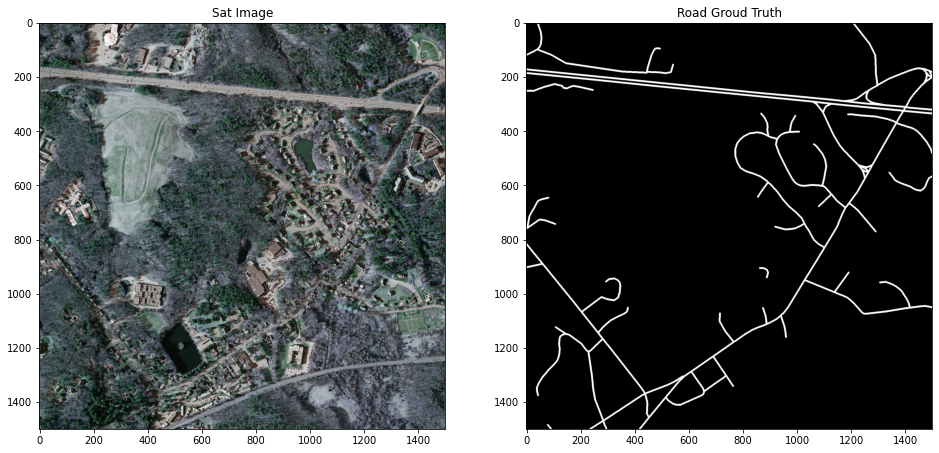

In [5]:
import cv2
import matplotlib.pyplot as plt
fig=plt.figure(figsize=(16, 16))
row=1
col =2
i=1
for imagePath, maskPath in pathMappinsgs:
        image = cv2.imread(imagePath)
        mask = cv2.imread(maskPath)
        fig.add_subplot(row, col, i)
        plt.imshow(image)
        plt.title("Sat Image")
        i+=1
        fig.add_subplot(row, col, i)
        plt.imshow(mask)
        plt.title("Road Groud Truth")
        i+=1
        break # display single image
plt.show()

### Parameters to help crop subimages from input image, and stiching back the prediction masks

In [6]:
ImageWidth = 1500
SubImageWidth = 224
subImagesPerRow = 8
strideLenght = int((ImageWidth-SubImageWidth)/(subImagesPerRow-1))


### Test subimage cropping from a single input image

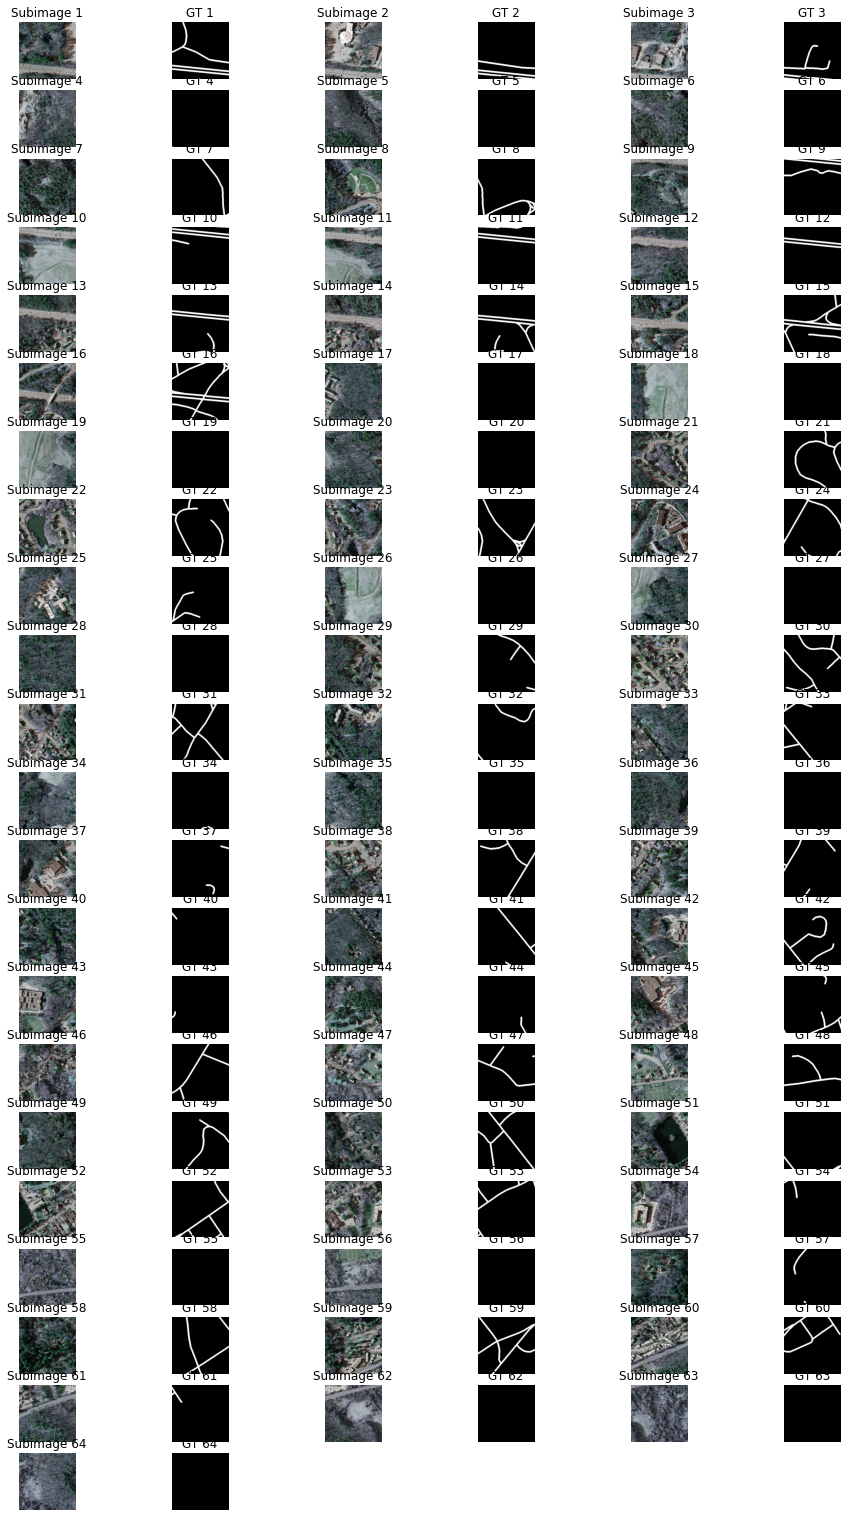

In [7]:
fig=plt.figure(figsize=(16, 80))
row = subImagesPerRow*subImagesPerRow
col = 6
i=1
for imagePath, maskPath in pathMappinsgs:
    image = cv2.imread(imagePath)
    mask = cv2.imread(maskPath)
    s= subimages_from_given_images(image, mask, stride=strideLenght, subImagesPerRow=subImagesPerRow)
    for j in range(1,row+1):
        subimg, submsk = next(s)
        #print(subimg.shape, j)
        fig.add_subplot(row, col, j*2-1)
        plt.imshow(subimg)
        plt.title("Subimage {}".format(j))
        plt.axis('off')
        
        fig.add_subplot(row, col, j*2)
        plt.imshow(submsk)
        plt.title("GT {}".format(j))
        plt.axis('off')
    break
plt.show()

### Make predictions on subimages from single input image

2/2 [==============================] - 0s 107ms/step


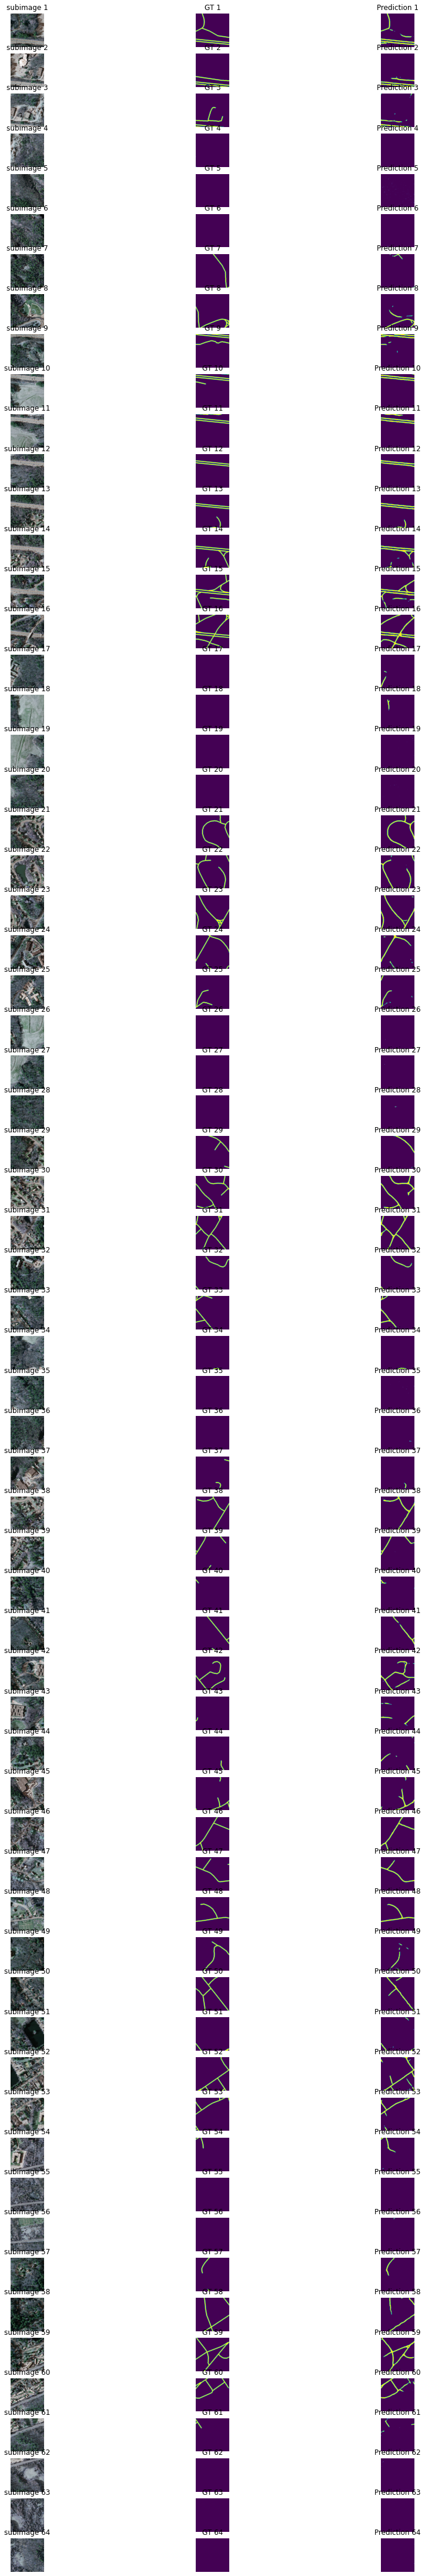

In [8]:
fig=plt.figure(figsize=(16, 80))
row = subImagesPerRow*subImagesPerRow
col = 3

for imagePath, maskPath in pathMappinsgs:
    image = cv2.imread(imagePath)
    mask = cv2.imread(maskPath,cv2.IMREAD_GRAYSCALE)
    
    ImgGen= subimages_from_given_images(image, mask, stride=strideLenght,  subImagesPerRow=subImagesPerRow)
    
    inputBatch = np.zeros((row, 224, 224, 3), dtype=np.float32)
    maskBatch = np.zeros((row, 224, 224), dtype=np.float32)
    for i in range(0,row):
        subimg, submsk = next(ImgGen)
        inputBatch[i] = subimg/255.
        maskBatch[i] = submsk/255.
    
    prediction = model.predict(inputBatch, verbose=1)
    
    for i in range(1,row+1):
        
        fig.add_subplot(row, col, i*3-2)
        plt.imshow(np.array(inputBatch[i-1]*255, dtype=np.uint8 ) )
        plt.title("subimage {}".format(i))
        plt.axis('off')
        
        fig.add_subplot(row, col, i*3-1)
        plt.imshow(np.array(maskBatch[i-1]*255, dtype=np.uint8 ) )
        plt.title("GT {}".format(i))
        plt.axis('off')
        
        fig.add_subplot(row, col, i*3)
        plt.imshow(prediction[i-1])
        plt.title("Prediction {}".format(i))
        plt.axis('off')
    break
plt.show()

## Prediction on Entire Test Set

2/2 [==============================] - 0s 145ms/step
71612 29285 19370 2129733
IoU: 0.5954418086424372, Accuracy: 0.9783755555555556, Recall: 0.7871007452023477, Precision: 0.7097535110062737
2/2 [==============================] - 0s 139ms/step
174549 51263 39335 1984853
IoU: 0.6583102957981799, Accuracy: 0.9597342222222223, Recall: 0.8160919002823961, Precision: 0.7729837209714275
2/2 [==============================] - 0s 139ms/step
184668 76716 81663 1906953
IoU: 0.5383169070127417, Accuracy: 0.9296093333333333, Recall: 0.6933777892922717, Precision: 0.706500780460931
2/2 [==============================] - 0s 139ms/step
211940 87165 78753 1872142
IoU: 0.5608985386044493, Accuracy: 0.9262586666666667, Recall: 0.729085323692005, Precision: 0.7085805987863794
2/2 [==============================] - 0s 139ms/step
33477 19757 21262 2175504
IoU: 0.4493798324742268, Accuracy: 0.9817693333333334, Recall: 0.611574928296096, Precision: 0.6288650110831423
2/2 [==============================] - 0

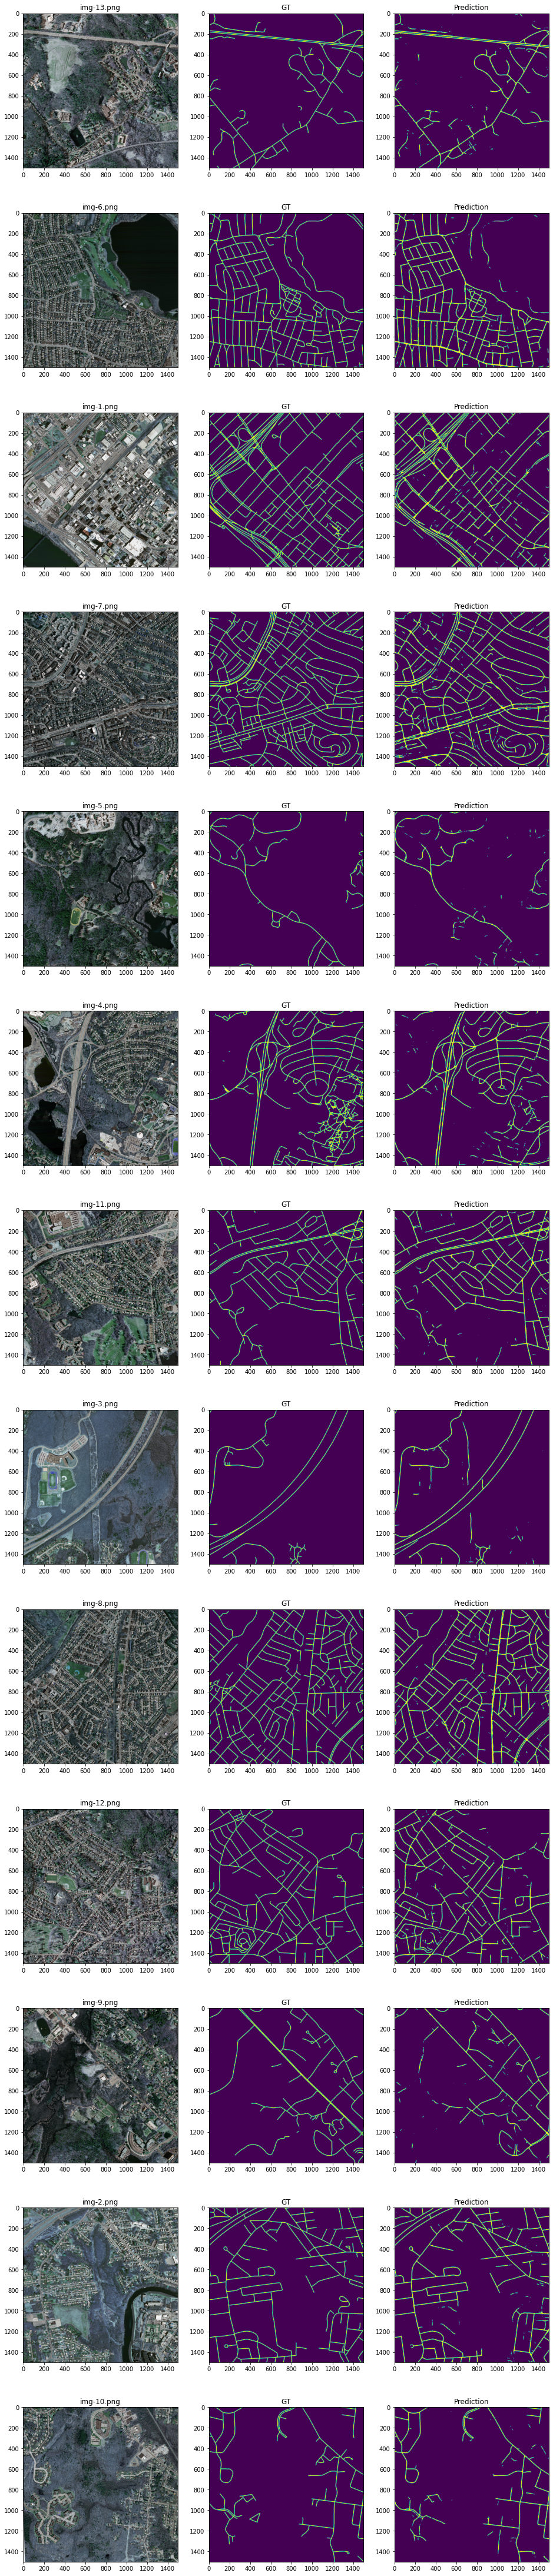

In [11]:
fig=plt.figure(figsize=(16, 80))
ImgCount = subImagesPerRow*subImagesPerRow
row = 13
col = 3
p = 1

performance_metrics = []

for imagePath, maskPath in pathMappinsgs:
    image = cv2.imread(imagePath)
    mask = cv2.imread(maskPath,cv2.IMREAD_GRAYSCALE)
    
    ImgGen= subimages_from_given_images(image, mask, stride=strideLenght, subImagesPerRow=subImagesPerRow)
    
    inputBatch = np.zeros((ImgCount, 224, 224, 3), dtype=np.float32)
    maskBatch = np.zeros((ImgCount, 224, 224), dtype=np.float32)
    for i in range(0,ImgCount):
        subimg, submsk = next(ImgGen)
        inputBatch[i] = subimg/255.
        maskBatch[i] = submsk/255.
    
    prediction = model.predict(inputBatch, verbose=1)
   
    # Stich all predictions
    pred1500 = np.zeros((1500, 1500), dtype=np.bool)
    for i in range(0, subImagesPerRow):
        for j in range(0, subImagesPerRow):
            sRow = i*strideLenght    
            eRow = sRow+224
            sCol= j*strideLenght
            eCol = sCol+224
            # pixel belongs to road if probabity is above 0.5 
            roadpred = prediction[i*subImagesPerRow + j]>0.5
            roadpred = np.moveaxis(roadpred, -1, 0)

            pred1500[sRow:eRow, sCol:eCol] = np.logical_or(roadpred[0], pred1500[sRow:eRow, sCol:eCol])
    
    metrics = iou_coef_numpy(mask, pred1500)
    print("IoU: {}, Accuracy: {}, Recall: {}, Precision: {}".format(*metrics))
    performance_metrics.append(metrics)
    
    fig.add_subplot(row,col,p)
    plt.imshow(image)
    p+=1
    plt.title("{}".format(os.path.basename(imagePath)))
    
    fig.add_subplot(row,col,p)
    plt.imshow(mask)
    p+=1
    plt.title("GT")
    
    fig.add_subplot(row,col,p)
    plt.imshow(pred1500)
    p+=1
    plt.title("Prediction")
    #break
plt.show()

#### As a Post Processing step, noisy non-road segments can be removed using connected component analysis. 

## Perfomance summary

In [12]:
avgIou = avgAccuracy = avgRecall = avgPrecision = 0
for Paths, metric in zip(pathMappinsgs, performance_metrics):
    print (Paths[0])
    print("IoU: {}, Accuracy: {}, Recall: {}, Precision: {}\n".format(*metric))
    Iou, accuracy, recall, precision = metric
    avgIou+=Iou
    avgAccuracy += accuracy
    avgRecall += recall
    avgPrecision += precision

avgIou /= len(performance_metrics)
avgAccuracy /= len(performance_metrics)
avgRecall /= len(performance_metrics)
avgPrecision /= len(performance_metrics)
print("\nAverage Values")
print("IoU: {}, Accuracy: {}, Recall: {}, Precision: {}\n".format(avgIou, avgAccuracy, avgRecall, avgPrecision))

/home/calm/Downloads/road_segmentation_ideal/testing/input/img-13.png
IoU: 0.5954418086424372, Accuracy: 0.9783755555555556, Recall: 0.7871007452023477, Precision: 0.7097535110062737

/home/calm/Downloads/road_segmentation_ideal/testing/input/img-6.png
IoU: 0.6583102957981799, Accuracy: 0.9597342222222223, Recall: 0.8160919002823961, Precision: 0.7729837209714275

/home/calm/Downloads/road_segmentation_ideal/testing/input/img-1.png
IoU: 0.5383169070127417, Accuracy: 0.9296093333333333, Recall: 0.6933777892922717, Precision: 0.706500780460931

/home/calm/Downloads/road_segmentation_ideal/testing/input/img-7.png
IoU: 0.5608985386044493, Accuracy: 0.9262586666666667, Recall: 0.729085323692005, Precision: 0.7085805987863794

/home/calm/Downloads/road_segmentation_ideal/testing/input/img-5.png
IoU: 0.4493798324742268, Accuracy: 0.9817693333333334, Recall: 0.611574928296096, Precision: 0.6288650110831423

/home/calm/Downloads/road_segmentation_ideal/testing/input/img-4.png
IoU: 0.53886515132